# Comparing models on different amounts of label noise

In [1]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

from blr import evaluation as blreval
from blr.data import Dataset
from blr.model import LRModel, BLRModel

WARNING (theano.tensor.blas): Using NumPy C-API based implementation for BLAS functions.


In [2]:
from sklearn.preprocessing import StandardScaler

In [3]:
%load_ext autoreload
%autoreload 2

## Runtime video:

https://www.youtube.com/watch?v=RQu3twVgnHQ

## Experiment Setup

* Use noise ranges from 5% to 40%
* Use standard scaling (feature distribution is heavily right-skewed, plus the Cauchy prior works best on standardized data)
* Use Normal(0,1) and Cauchy(0,2.5) priors
* Compare the trace statistics between priors and noise types
* Only choose select plots to show; save the rest for the appendix
* Compare performance with the frequentist LR

## Getting the data

In [4]:
df = pd.read_csv('../data/spambase.data', header=None)
print(df.shape)
df.columns = [
    line[:-1]
    for line in open('../../spambase-cols.txt', 'r')
]
df.head()

(4601, 58)


word_freq_make  word_freq_address  word_freq_all  word_freq_3d  \
0            0.00               0.64           0.64           0.0   
1            0.21               0.28           0.50           0.0   
2            0.06               0.00           0.71           0.0   
3            0.00               0.00           0.00           0.0   
4            0.00               0.00           0.00           0.0   

   word_freq_our  word_freq_over  word_freq_remove  word_freq_internet  \
0           0.32            0.00              0.00                0.00   
1           0.14            0.28              0.21                0.07   
2           1.23            0.19              0.19                0.12   
3           0.63            0.00              0.31                0.63   
4           0.63            0.00              0.31                0.63   

   word_freq_order  word_freq_mail  ...  char_freq_;  char_freq_(  \
0             0.00            0.00  ...         0.00        0.000   
1             0.00            0.94  ...         0.00        0.132   
2             0.64            0.25  ...         0.01        0.143   
3             0.31            0.63  ...         0.00        0.137   
4             0.31            0.63  ...         0.00        0.135   

   char_freq_[  char_freq_!  char_freq_$  char_freq_#  \
0          0.0        0.778        0.000        0.000   
1          0.0        0.372        0.180        0.048   
2          0.0        0.276        0.184        0.010   
3          0.0        0.137        0.000        0.000   
4          0.0        0.135        0.000        0.000   

   capital_run_length_average  capital_run_length_longest  \
0                       3.756                          61   
1                       5.114                         101   
2                       9.821                         485   
3                       3.537                          40   
4                       3.537                          40   

   capital_run_length_total  spam  
0                       278     1  
1                      1028     1  
2                      2259     1  
3                       191     1  
4                       191     1  

[5 rows x 58 columns]

In [5]:
X, y = df[[x for x in df.columns if x != 'spam']], df['spam']

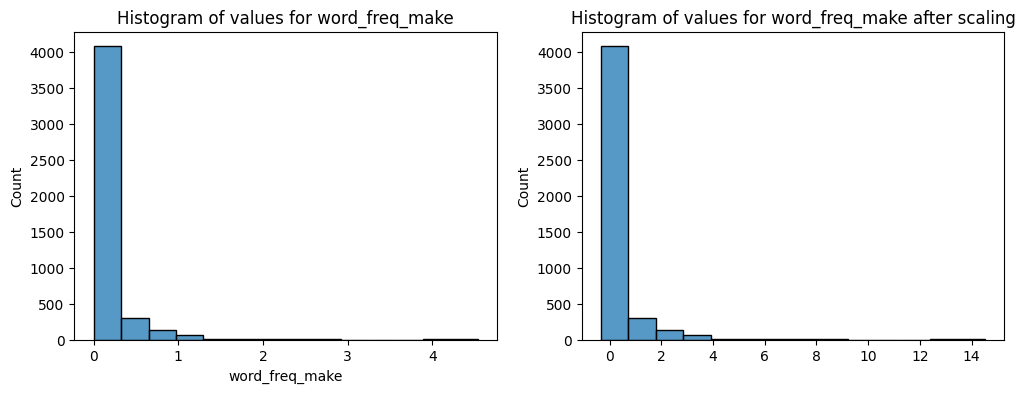

In [6]:
fig, axs = plt.subplots(1, 2, figsize=(12, 4))
ax=axs[0]
sns.histplot(X['word_freq_make'], ax=ax)
ax.set_title('Histogram of values for word_freq_make')

_X = StandardScaler().fit_transform(X)
ax=axs[1]
sns.histplot(_X[:, 0], ax=ax)
ax.set_title('Histogram of values for word_freq_make after scaling')

fig.savefig('feature_histogram.png')

In [7]:
_X.shape

(4601, 57)

## Running the experiment

In [8]:
noise_space = [0., 0.05, 0.1, 0.2, 0.3, 0.4]

y_tests = []
lr_preds = []
blr_preds = []
lr_models = []
blr_models = []

traces = []
tracesums = []

In [9]:
prior = 'cauchy'  # normal or cauchy

In [10]:
features = X.columns.values

In [11]:
UniformDataset = Dataset(X, y, noise_type='uniform')
PUDataset = Dataset(X, y, noise_type='pu')

In [12]:
for Xtr, Xts, ytr, yts in UniformDataset.generate_splits_from_parameters(noise_space):
    print("Generating uniform-noise splits..")
    
    print("Running base linear regression..")
    model = LRModel(features)
    model.fit(Xtr, ytr)
    y_pred = model.predict_proba(Xts)
    
    y_tests.append(yts)
    lr_preds.append(y_pred)
    lr_models.append(model)
    
    print("Running Bayesian linear regression..")
    model = BLRModel(Xtr, ytr, features, prior=prior)
    _ = model.fit()
    
    traces.append(model.trace)
    tracesums.append(model.get_trace_summary())

    y_pred = model.predict_proba(Xts)
    
    blr_preds.append(y_pred)
    blr_models.append(model)

Generating uniform-noise splits..
Running base linear regression..
Running Bayesian linear regression..


/home/franciszacdlc/.pyenv/versions/3.9.14/envs/base3.9/lib/python3.9/site-packages/deprecat/classic.py:215: FutureWarning: In v4.0, pm.sample will return an `arviz.InferenceData` object instead of a `MultiTrace` by default. You can pass return_inferencedata=True or return_inferencedata=False to be safe and silence this warning.
  return wrapped_(*args_, **kwargs_)
Auto-assigning NUTS sampler...
Initializing NUTS using adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [lr_bias, lr_weights]


Sampling 4 chains for 500 tune and 500 draw iterations (2_000 + 2_000 draws total) took 867 seconds.
The acceptance probability does not match the target. It is 0.8789330256770205, but should be close to 0.8. Try to increase the number of tuning steps.
Got error No model on context stack. trying to find log_likelihood in translation.
/home/franciszacdlc/.pyenv/versions/3.9.14/envs/base3.9/lib/python3.9/site-packages/arviz/data/io_pymc3_3x.py:98: FutureWarning: Using `from_pymc3` without the model will be deprecated in a future release. Not using the model will return less accurate and less useful results. Make sure you use the model argument or call from_pymc3 within a model context.
  warnings.warn(
/home/franciszacdlc/.pyenv/versions/3.9.14/envs/base3.9/lib/python3.9/site-packages/pymc3/sampling.py:1708: UserWarning: samples parameter is smaller than nchains times ndraws, some draws and/or chains may not be represented in the returned posterior predictive sample
  warnings.warn(


Generating uniform-noise splits..
Running base linear regression..
Running Bayesian linear regression..


/home/franciszacdlc/.pyenv/versions/3.9.14/envs/base3.9/lib/python3.9/site-packages/deprecat/classic.py:215: FutureWarning: In v4.0, pm.sample will return an `arviz.InferenceData` object instead of a `MultiTrace` by default. You can pass return_inferencedata=True or return_inferencedata=False to be safe and silence this warning.
  return wrapped_(*args_, **kwargs_)
Auto-assigning NUTS sampler...
Initializing NUTS using adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [lr_bias, lr_weights]


Sampling 4 chains for 500 tune and 500 draw iterations (2_000 + 2_000 draws total) took 157 seconds.
Got error No model on context stack. trying to find log_likelihood in translation.
/home/franciszacdlc/.pyenv/versions/3.9.14/envs/base3.9/lib/python3.9/site-packages/arviz/data/io_pymc3_3x.py:98: FutureWarning: Using `from_pymc3` without the model will be deprecated in a future release. Not using the model will return less accurate and less useful results. Make sure you use the model argument or call from_pymc3 within a model context.
  warnings.warn(
/home/franciszacdlc/.pyenv/versions/3.9.14/envs/base3.9/lib/python3.9/site-packages/pymc3/sampling.py:1708: UserWarning: samples parameter is smaller than nchains times ndraws, some draws and/or chains may not be represented in the returned posterior predictive sample
  warnings.warn(


Generating uniform-noise splits..
Running base linear regression..
Running Bayesian linear regression..


/home/franciszacdlc/.pyenv/versions/3.9.14/envs/base3.9/lib/python3.9/site-packages/deprecat/classic.py:215: FutureWarning: In v4.0, pm.sample will return an `arviz.InferenceData` object instead of a `MultiTrace` by default. You can pass return_inferencedata=True or return_inferencedata=False to be safe and silence this warning.
  return wrapped_(*args_, **kwargs_)
Auto-assigning NUTS sampler...
Initializing NUTS using adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [lr_bias, lr_weights]


Sampling 4 chains for 500 tune and 500 draw iterations (2_000 + 2_000 draws total) took 214 seconds.
The number of effective samples is smaller than 25% for some parameters.
Got error No model on context stack. trying to find log_likelihood in translation.
/home/franciszacdlc/.pyenv/versions/3.9.14/envs/base3.9/lib/python3.9/site-packages/arviz/data/io_pymc3_3x.py:98: FutureWarning: Using `from_pymc3` without the model will be deprecated in a future release. Not using the model will return less accurate and less useful results. Make sure you use the model argument or call from_pymc3 within a model context.
  warnings.warn(
/home/franciszacdlc/.pyenv/versions/3.9.14/envs/base3.9/lib/python3.9/site-packages/pymc3/sampling.py:1708: UserWarning: samples parameter is smaller than nchains times ndraws, some draws and/or chains may not be represented in the returned posterior predictive sample
  warnings.warn(


Generating uniform-noise splits..
Running base linear regression..
Running Bayesian linear regression..


/home/franciszacdlc/.pyenv/versions/3.9.14/envs/base3.9/lib/python3.9/site-packages/deprecat/classic.py:215: FutureWarning: In v4.0, pm.sample will return an `arviz.InferenceData` object instead of a `MultiTrace` by default. You can pass return_inferencedata=True or return_inferencedata=False to be safe and silence this warning.
  return wrapped_(*args_, **kwargs_)
Auto-assigning NUTS sampler...
Initializing NUTS using adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [lr_bias, lr_weights]


Sampling 4 chains for 500 tune and 500 draw iterations (2_000 + 2_000 draws total) took 240 seconds.
Got error No model on context stack. trying to find log_likelihood in translation.
/home/franciszacdlc/.pyenv/versions/3.9.14/envs/base3.9/lib/python3.9/site-packages/arviz/data/io_pymc3_3x.py:98: FutureWarning: Using `from_pymc3` without the model will be deprecated in a future release. Not using the model will return less accurate and less useful results. Make sure you use the model argument or call from_pymc3 within a model context.
  warnings.warn(
/home/franciszacdlc/.pyenv/versions/3.9.14/envs/base3.9/lib/python3.9/site-packages/pymc3/sampling.py:1708: UserWarning: samples parameter is smaller than nchains times ndraws, some draws and/or chains may not be represented in the returned posterior predictive sample
  warnings.warn(


Generating uniform-noise splits..
Running base linear regression..
Running Bayesian linear regression..


/home/franciszacdlc/.pyenv/versions/3.9.14/envs/base3.9/lib/python3.9/site-packages/deprecat/classic.py:215: FutureWarning: In v4.0, pm.sample will return an `arviz.InferenceData` object instead of a `MultiTrace` by default. You can pass return_inferencedata=True or return_inferencedata=False to be safe and silence this warning.
  return wrapped_(*args_, **kwargs_)
Auto-assigning NUTS sampler...
Initializing NUTS using adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [lr_bias, lr_weights]


Sampling 4 chains for 500 tune and 500 draw iterations (2_000 + 2_000 draws total) took 225 seconds.
The number of effective samples is smaller than 25% for some parameters.
Got error No model on context stack. trying to find log_likelihood in translation.
/home/franciszacdlc/.pyenv/versions/3.9.14/envs/base3.9/lib/python3.9/site-packages/arviz/data/io_pymc3_3x.py:98: FutureWarning: Using `from_pymc3` without the model will be deprecated in a future release. Not using the model will return less accurate and less useful results. Make sure you use the model argument or call from_pymc3 within a model context.
  warnings.warn(
/home/franciszacdlc/.pyenv/versions/3.9.14/envs/base3.9/lib/python3.9/site-packages/pymc3/sampling.py:1708: UserWarning: samples parameter is smaller than nchains times ndraws, some draws and/or chains may not be represented in the returned posterior predictive sample
  warnings.warn(


Generating uniform-noise splits..
Running base linear regression..
Running Bayesian linear regression..


/home/franciszacdlc/.pyenv/versions/3.9.14/envs/base3.9/lib/python3.9/site-packages/deprecat/classic.py:215: FutureWarning: In v4.0, pm.sample will return an `arviz.InferenceData` object instead of a `MultiTrace` by default. You can pass return_inferencedata=True or return_inferencedata=False to be safe and silence this warning.
  return wrapped_(*args_, **kwargs_)
Auto-assigning NUTS sampler...
Initializing NUTS using adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [lr_bias, lr_weights]


Sampling 4 chains for 500 tune and 500 draw iterations (2_000 + 2_000 draws total) took 331 seconds.
Got error No model on context stack. trying to find log_likelihood in translation.
/home/franciszacdlc/.pyenv/versions/3.9.14/envs/base3.9/lib/python3.9/site-packages/arviz/data/io_pymc3_3x.py:98: FutureWarning: Using `from_pymc3` without the model will be deprecated in a future release. Not using the model will return less accurate and less useful results. Make sure you use the model argument or call from_pymc3 within a model context.
  warnings.warn(
/home/franciszacdlc/.pyenv/versions/3.9.14/envs/base3.9/lib/python3.9/site-packages/pymc3/sampling.py:1708: UserWarning: samples parameter is smaller than nchains times ndraws, some draws and/or chains may not be represented in the returned posterior predictive sample
  warnings.warn(


In [13]:
for Xtr, Xts, ytr, yts in PUDataset.generate_splits_from_parameters(noise_space):
    print("Generating PU-noise splits..")
    
    print("Running base linear regression..")
    model = LRModel(features)
    model.fit(Xtr, ytr)
    y_pred = model.predict_proba(Xts)
    
    y_tests.append(yts)
    lr_preds.append(y_pred)
    lr_models.append(model)
    
    print("Running Bayesian linear regression..")
    model = BLRModel(Xtr, ytr, features, prior=prior)
    _ = model.fit()
    
    traces.append(model.trace)
    tracesums.append(model.get_trace_summary())

    y_pred = model.predict_proba(Xts)
    
    blr_preds.append(y_pred)
    blr_models.append(model)

Generating PU-noise splits..
Running base linear regression..
Running Bayesian linear regression..


/home/franciszacdlc/.pyenv/versions/3.9.14/envs/base3.9/lib/python3.9/site-packages/deprecat/classic.py:215: FutureWarning: In v4.0, pm.sample will return an `arviz.InferenceData` object instead of a `MultiTrace` by default. You can pass return_inferencedata=True or return_inferencedata=False to be safe and silence this warning.
  return wrapped_(*args_, **kwargs_)
Auto-assigning NUTS sampler...
Initializing NUTS using adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [lr_bias, lr_weights]


Sampling 4 chains for 500 tune and 500 draw iterations (2_000 + 2_000 draws total) took 593 seconds.
The acceptance probability does not match the target. It is 0.8876104865771017, but should be close to 0.8. Try to increase the number of tuning steps.
Got error No model on context stack. trying to find log_likelihood in translation.
/home/franciszacdlc/.pyenv/versions/3.9.14/envs/base3.9/lib/python3.9/site-packages/arviz/data/io_pymc3_3x.py:98: FutureWarning: Using `from_pymc3` without the model will be deprecated in a future release. Not using the model will return less accurate and less useful results. Make sure you use the model argument or call from_pymc3 within a model context.
  warnings.warn(
/home/franciszacdlc/.pyenv/versions/3.9.14/envs/base3.9/lib/python3.9/site-packages/pymc3/sampling.py:1708: UserWarning: samples parameter is smaller than nchains times ndraws, some draws and/or chains may not be represented in the returned posterior predictive sample
  warnings.warn(


Generating PU-noise splits..
Running base linear regression..
Running Bayesian linear regression..


/home/franciszacdlc/.pyenv/versions/3.9.14/envs/base3.9/lib/python3.9/site-packages/deprecat/classic.py:215: FutureWarning: In v4.0, pm.sample will return an `arviz.InferenceData` object instead of a `MultiTrace` by default. You can pass return_inferencedata=True or return_inferencedata=False to be safe and silence this warning.
  return wrapped_(*args_, **kwargs_)
Auto-assigning NUTS sampler...
Initializing NUTS using adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [lr_bias, lr_weights]


Sampling 4 chains for 500 tune and 500 draw iterations (2_000 + 2_000 draws total) took 413 seconds.
The acceptance probability does not match the target. It is 0.89400608896543, but should be close to 0.8. Try to increase the number of tuning steps.
The estimated number of effective samples is smaller than 200 for some parameters.
Got error No model on context stack. trying to find log_likelihood in translation.
/home/franciszacdlc/.pyenv/versions/3.9.14/envs/base3.9/lib/python3.9/site-packages/arviz/data/io_pymc3_3x.py:98: FutureWarning: Using `from_pymc3` without the model will be deprecated in a future release. Not using the model will return less accurate and less useful results. Make sure you use the model argument or call from_pymc3 within a model context.
  warnings.warn(
/home/franciszacdlc/.pyenv/versions/3.9.14/envs/base3.9/lib/python3.9/site-packages/pymc3/sampling.py:1708: UserWarning: samples parameter is smaller than nchains times ndraws, some draws and/or chains may not

Generating PU-noise splits..
Running base linear regression..
Running Bayesian linear regression..


/home/franciszacdlc/.pyenv/versions/3.9.14/envs/base3.9/lib/python3.9/site-packages/deprecat/classic.py:215: FutureWarning: In v4.0, pm.sample will return an `arviz.InferenceData` object instead of a `MultiTrace` by default. You can pass return_inferencedata=True or return_inferencedata=False to be safe and silence this warning.
  return wrapped_(*args_, **kwargs_)
Auto-assigning NUTS sampler...
Initializing NUTS using adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [lr_bias, lr_weights]


Sampling 4 chains for 500 tune and 500 draw iterations (2_000 + 2_000 draws total) took 480 seconds.
The acceptance probability does not match the target. It is 0.891744575500864, but should be close to 0.8. Try to increase the number of tuning steps.
The acceptance probability does not match the target. It is 0.8939845965834381, but should be close to 0.8. Try to increase the number of tuning steps.
Got error No model on context stack. trying to find log_likelihood in translation.
/home/franciszacdlc/.pyenv/versions/3.9.14/envs/base3.9/lib/python3.9/site-packages/arviz/data/io_pymc3_3x.py:98: FutureWarning: Using `from_pymc3` without the model will be deprecated in a future release. Not using the model will return less accurate and less useful results. Make sure you use the model argument or call from_pymc3 within a model context.
  warnings.warn(
/home/franciszacdlc/.pyenv/versions/3.9.14/envs/base3.9/lib/python3.9/site-packages/pymc3/sampling.py:1708: UserWarning: samples parameter 

Generating PU-noise splits..
Running base linear regression..
Running Bayesian linear regression..


/home/franciszacdlc/.pyenv/versions/3.9.14/envs/base3.9/lib/python3.9/site-packages/deprecat/classic.py:215: FutureWarning: In v4.0, pm.sample will return an `arviz.InferenceData` object instead of a `MultiTrace` by default. You can pass return_inferencedata=True or return_inferencedata=False to be safe and silence this warning.
  return wrapped_(*args_, **kwargs_)
Auto-assigning NUTS sampler...
Initializing NUTS using adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [lr_bias, lr_weights]


Sampling 4 chains for 500 tune and 500 draw iterations (2_000 + 2_000 draws total) took 348 seconds.
The acceptance probability does not match the target. It is 0.8915819054476278, but should be close to 0.8. Try to increase the number of tuning steps.
Got error No model on context stack. trying to find log_likelihood in translation.
/home/franciszacdlc/.pyenv/versions/3.9.14/envs/base3.9/lib/python3.9/site-packages/arviz/data/io_pymc3_3x.py:98: FutureWarning: Using `from_pymc3` without the model will be deprecated in a future release. Not using the model will return less accurate and less useful results. Make sure you use the model argument or call from_pymc3 within a model context.
  warnings.warn(
/home/franciszacdlc/.pyenv/versions/3.9.14/envs/base3.9/lib/python3.9/site-packages/pymc3/sampling.py:1708: UserWarning: samples parameter is smaller than nchains times ndraws, some draws and/or chains may not be represented in the returned posterior predictive sample
  warnings.warn(


Generating PU-noise splits..
Running base linear regression..
Running Bayesian linear regression..


/home/franciszacdlc/.pyenv/versions/3.9.14/envs/base3.9/lib/python3.9/site-packages/deprecat/classic.py:215: FutureWarning: In v4.0, pm.sample will return an `arviz.InferenceData` object instead of a `MultiTrace` by default. You can pass return_inferencedata=True or return_inferencedata=False to be safe and silence this warning.
  return wrapped_(*args_, **kwargs_)
Auto-assigning NUTS sampler...
Initializing NUTS using adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [lr_bias, lr_weights]


Sampling 4 chains for 500 tune and 500 draw iterations (2_000 + 2_000 draws total) took 606 seconds.
There was 1 divergence after tuning. Increase `target_accept` or reparameterize.
The acceptance probability does not match the target. It is 0.9171565087879808, but should be close to 0.8. Try to increase the number of tuning steps.
The acceptance probability does not match the target. It is 0.8910976220521301, but should be close to 0.8. Try to increase the number of tuning steps.
The acceptance probability does not match the target. It is 0.8979051147207695, but should be close to 0.8. Try to increase the number of tuning steps.
The number of effective samples is smaller than 25% for some parameters.
Got error No model on context stack. trying to find log_likelihood in translation.
/home/franciszacdlc/.pyenv/versions/3.9.14/envs/base3.9/lib/python3.9/site-packages/arviz/data/io_pymc3_3x.py:98: FutureWarning: Using `from_pymc3` without the model will be deprecated in a future release. 

Generating PU-noise splits..
Running base linear regression..
Running Bayesian linear regression..


/home/franciszacdlc/.pyenv/versions/3.9.14/envs/base3.9/lib/python3.9/site-packages/deprecat/classic.py:215: FutureWarning: In v4.0, pm.sample will return an `arviz.InferenceData` object instead of a `MultiTrace` by default. You can pass return_inferencedata=True or return_inferencedata=False to be safe and silence this warning.
  return wrapped_(*args_, **kwargs_)
Auto-assigning NUTS sampler...
Initializing NUTS using adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [lr_bias, lr_weights]


Sampling 4 chains for 500 tune and 500 draw iterations (2_000 + 2_000 draws total) took 1499 seconds.
There were 16 divergences after tuning. Increase `target_accept` or reparameterize.
The number of effective samples is smaller than 25% for some parameters.
Got error No model on context stack. trying to find log_likelihood in translation.
/home/franciszacdlc/.pyenv/versions/3.9.14/envs/base3.9/lib/python3.9/site-packages/arviz/data/io_pymc3_3x.py:98: FutureWarning: Using `from_pymc3` without the model will be deprecated in a future release. Not using the model will return less accurate and less useful results. Make sure you use the model argument or call from_pymc3 within a model context.
  warnings.warn(
/home/franciszacdlc/.pyenv/versions/3.9.14/envs/base3.9/lib/python3.9/site-packages/pymc3/sampling.py:1708: UserWarning: samples parameter is smaller than nchains times ndraws, some draws and/or chains may not be represented in the returned posterior predictive sample
  warnings.warn

In [14]:
for t in tracesums:
    t.index = (list(features) + ['bias'])

In [15]:
len(tracesums)

12

## Generating the results

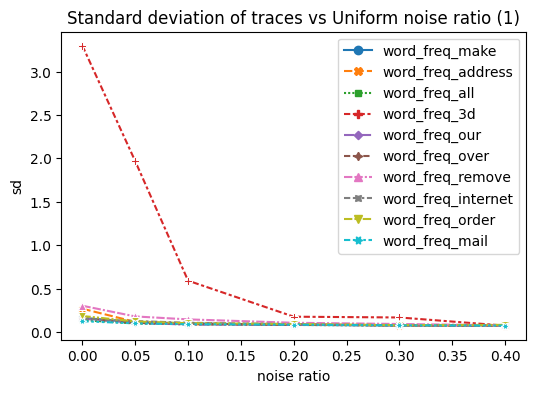

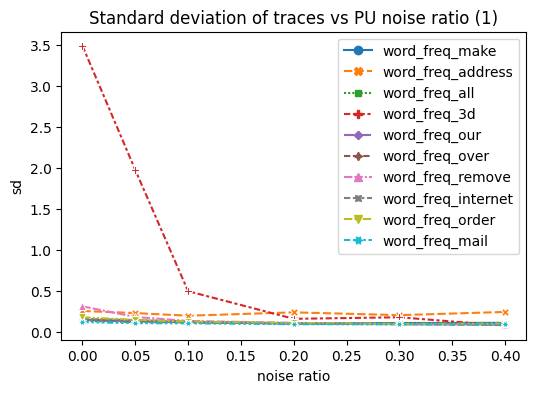

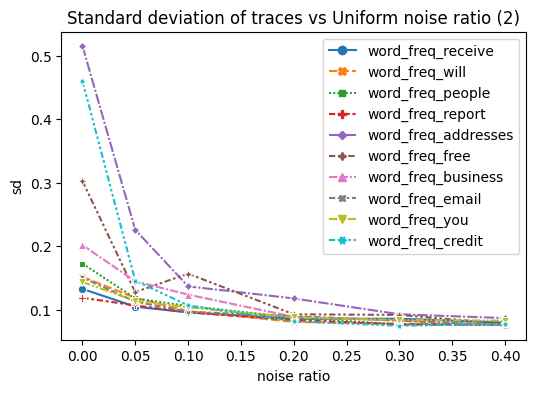

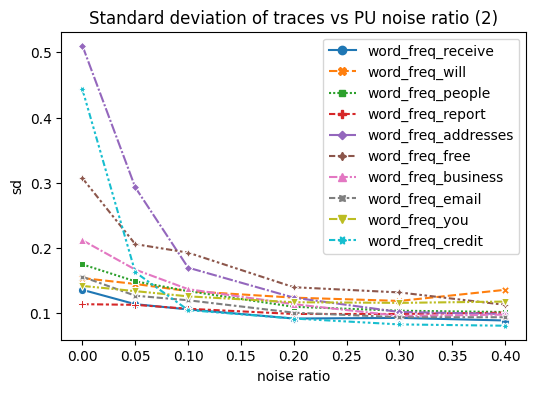

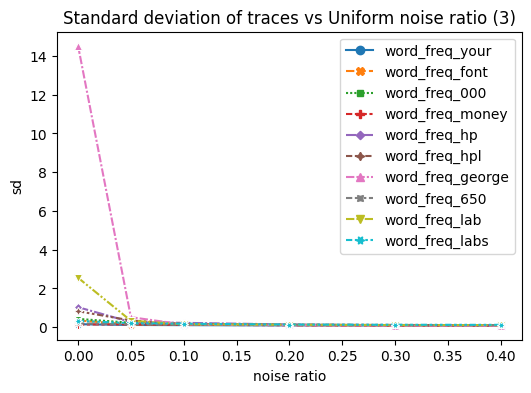

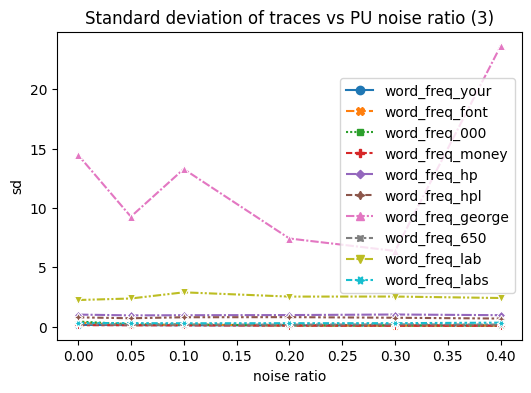

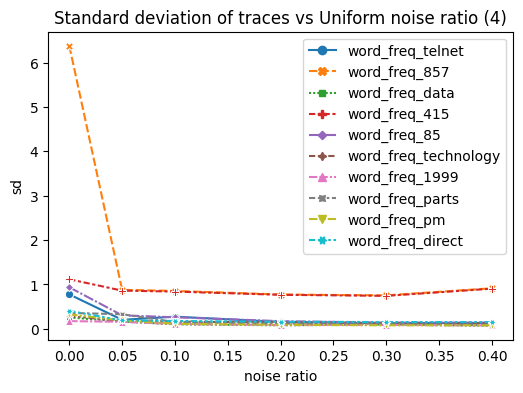

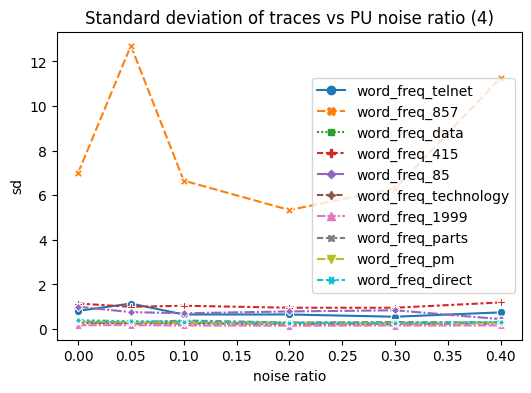

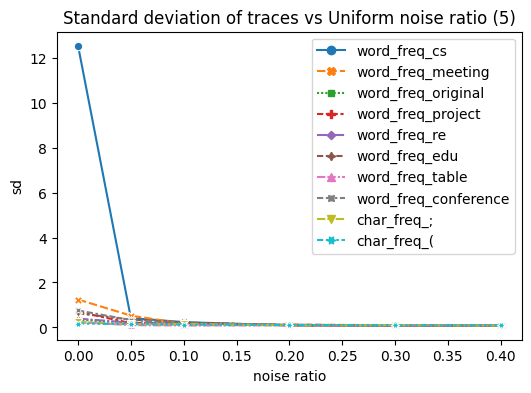

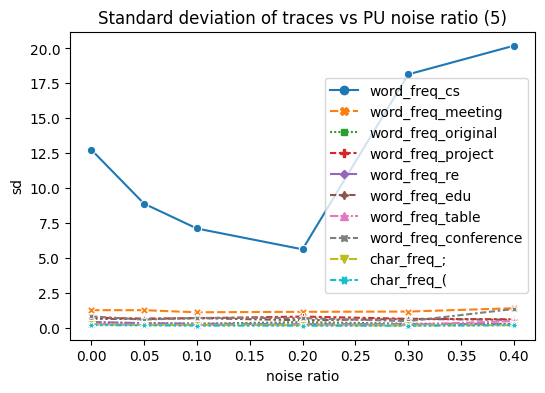

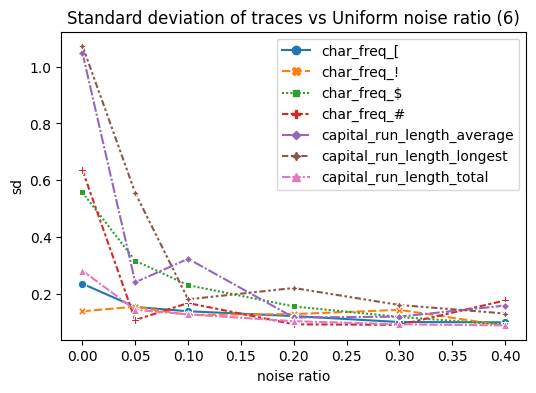

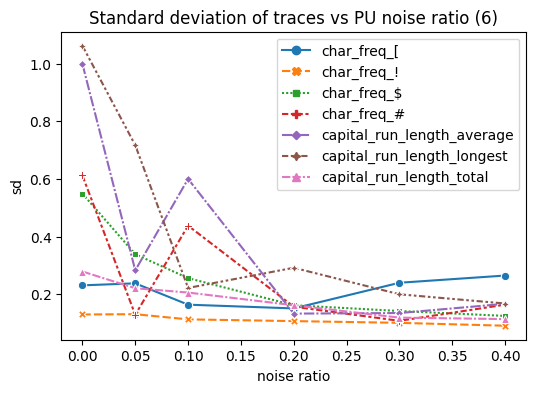

In [16]:
for i in range(6):
    feats = features[i*10 : min(i*10+10,len(features))]

    title = f'Standard deviation of traces vs Uniform noise ratio ({i+1})'
    fig, ax = blreval.generate_tracesum_plot(feats, noise_space, tracesums[:6], title)
    fig.savefig(f'std_uniform_noise_{prior}_prior_{i+1}.png')
    
    title = f'Standard deviation of traces vs PU noise ratio ({i+1})'
    fig, ax = blreval.generate_tracesum_plot(feats, noise_space, tracesums[6:], title)
    fig.savefig(f'std_pu_noise_{prior}_prior_{i+1}.png')

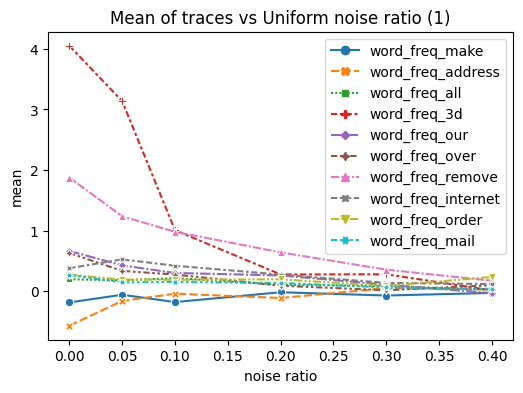

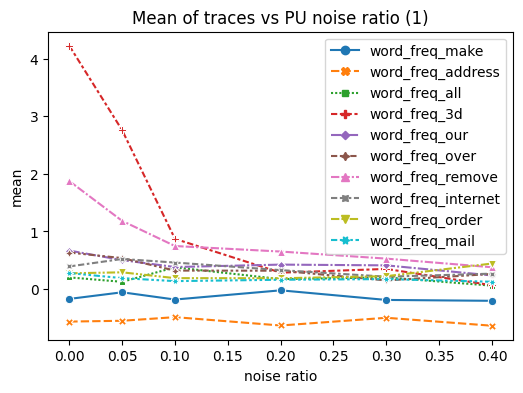

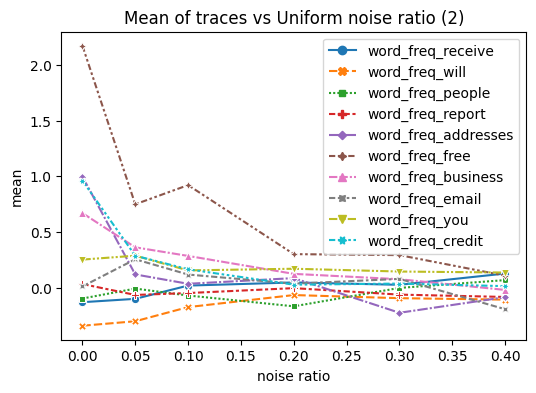

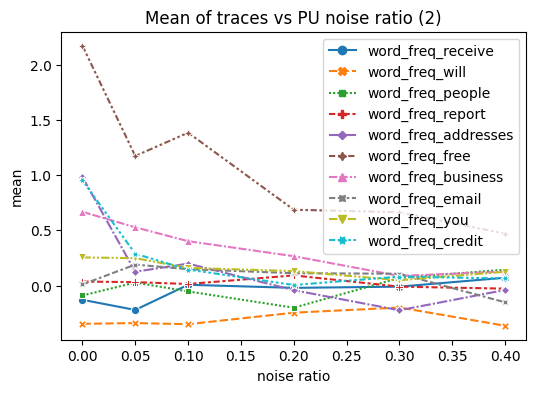

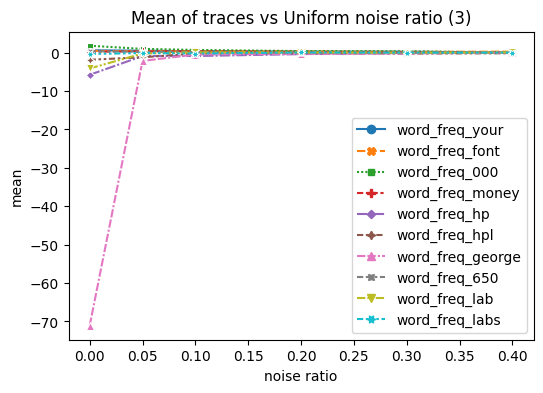

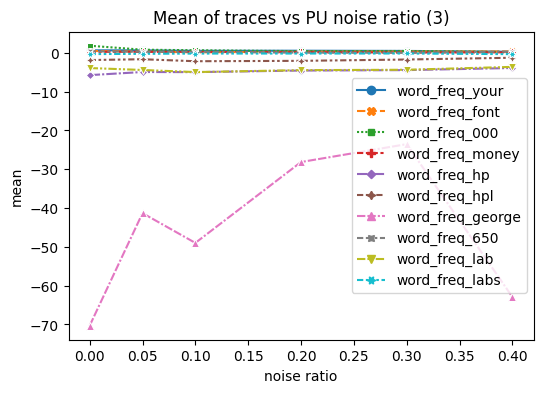

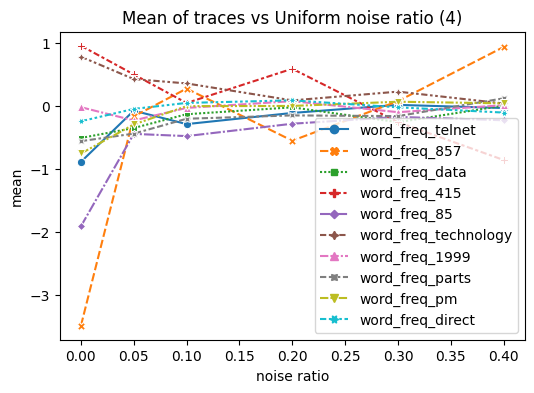

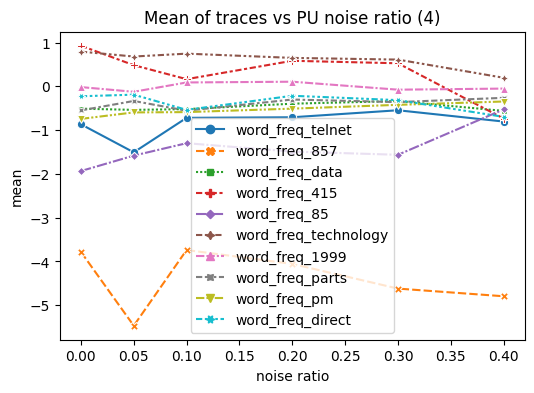

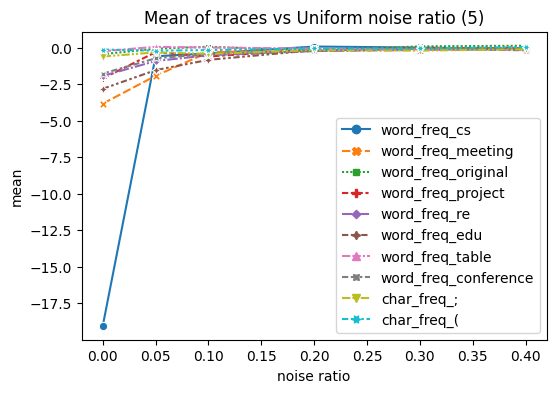

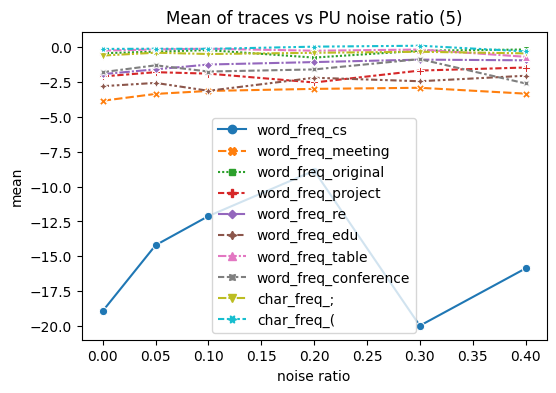

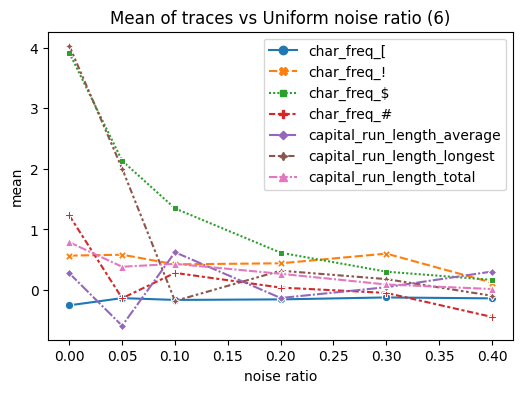

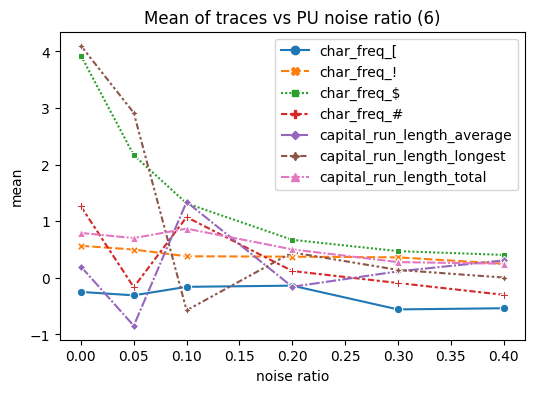

In [18]:
for i in range(6):
    feats = features[i*10 : min(i*10+10,len(features))]

    title = f'Mean of traces vs Uniform noise ratio ({i+1})'
    fig, ax = blreval.generate_tracesum_plot(feats, noise_space, tracesums[:6], title, v='mean')
    fig.savefig(f'mean_uniform_noise_{prior}_prior_{i+1}.png')
    
    title = f'Mean of traces vs PU noise ratio ({i+1})'
    fig, ax = blreval.generate_tracesum_plot(feats, noise_space, tracesums[6:], title, v='mean')
    fig.savefig(f'mean_pu_noise_{prior}_prior_{i+1}.png')

### Trace plots

In [19]:
rawtraces = [m.get_raw_trace() for m in blr_models]

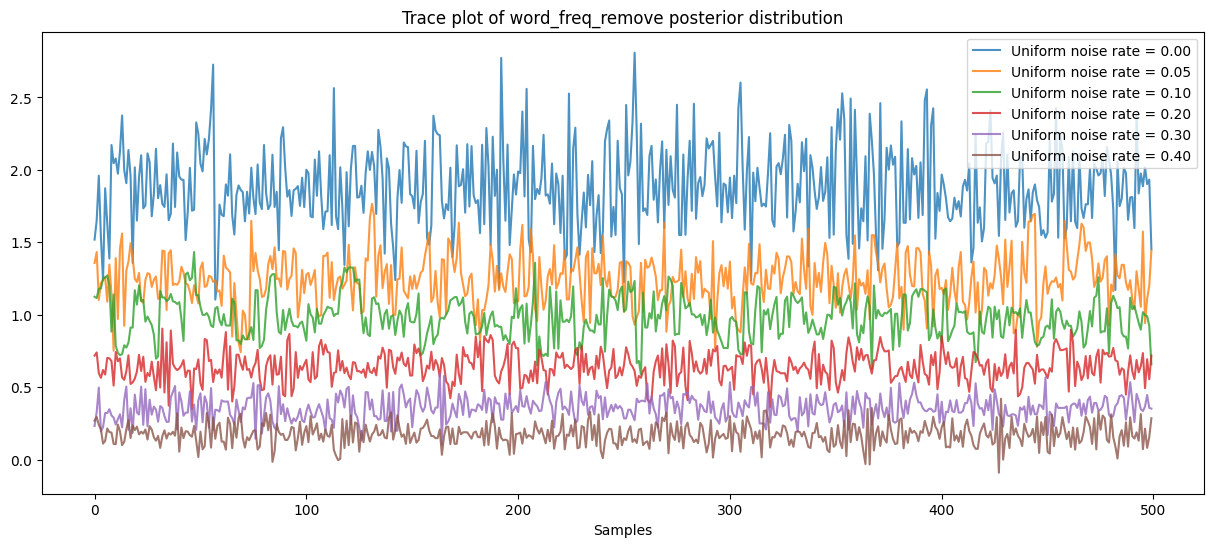

In [20]:
fig, ax = plt.subplots(figsize=(15, 6))

for i in range(len(noise_space)):
    ax.plot(rawtraces[i]['word_freq_remove'], alpha=0.8, label=f'Uniform noise rate = {noise_space[i]:.2f}')

ax.legend()
ax.set_xlabel('Samples')
ax.set_title('Trace plot of word_freq_remove posterior distribution')
fig.savefig(f'traceplot_word_freq_remove_{prior}_prior_uniform.png')

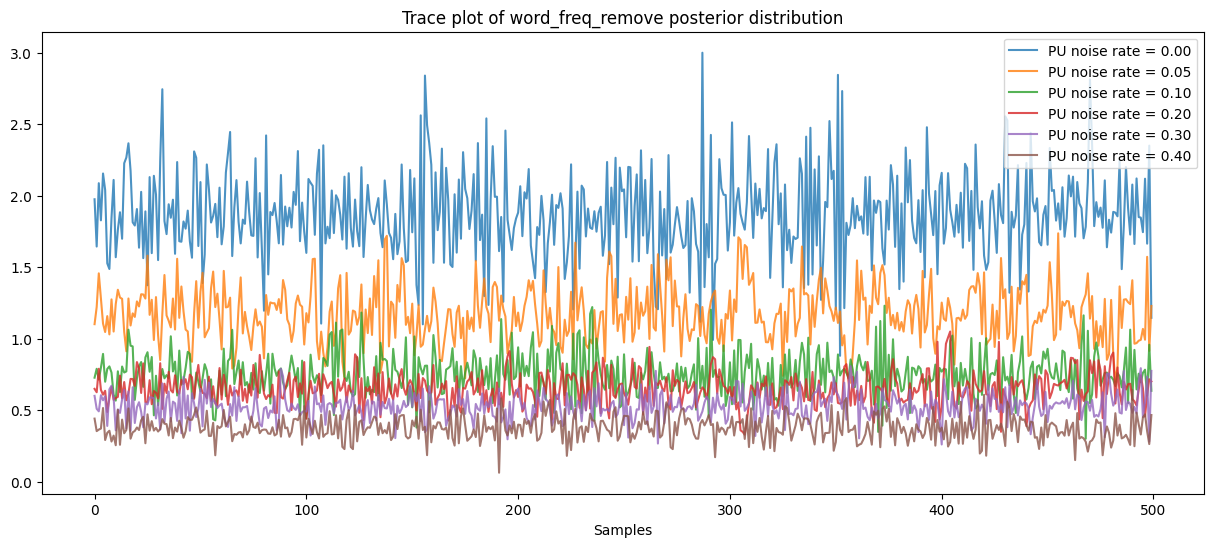

In [21]:
fig, ax = plt.subplots(figsize=(15, 6))

for i in range(len(noise_space)):
    ax.plot(rawtraces[i+6]['word_freq_remove'], alpha=0.8, label=f'PU noise rate = {noise_space[i]:.2f}')

ax.legend()
ax.set_xlabel('Samples')
ax.set_title('Trace plot of word_freq_remove posterior distribution')
fig.savefig(f'traceplot_word_freq_remove_{prior}_prior_pu.png')

### Comparing coefficients

In [22]:
coefs = [m.get_coefficients() for m in lr_models]

In [23]:
meandiffs = []

for i in range(12):
    blr_means = tracesums[i][['mean']]
    lr_means = coefs[i].set_index('feature')
    _df = blr_means.merge(lr_means, left_index=True, right_index=True)
    _df['diff'] = 100 * (_df['mean'] - _df['coef']) / _df['mean']
    _df = _df.rename({'mean': 'bayesian_posterior_mean', 'coef': 'standard_coefficients'}, axis=1)
    meandiffs.append(_df)

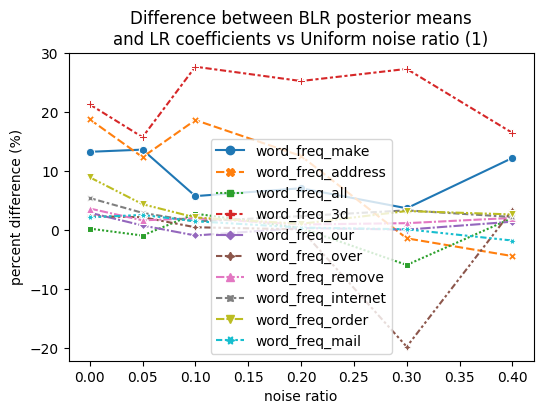

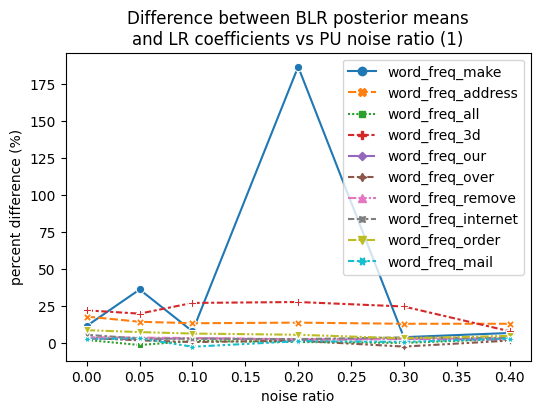

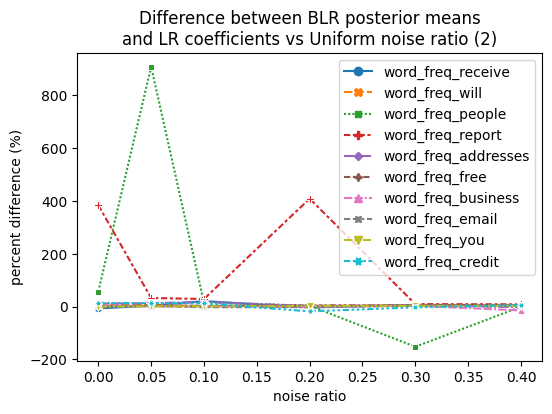

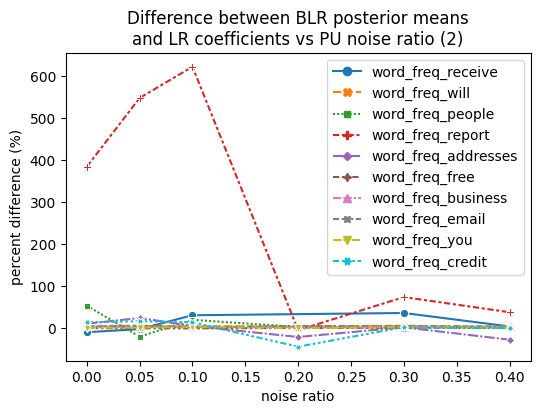

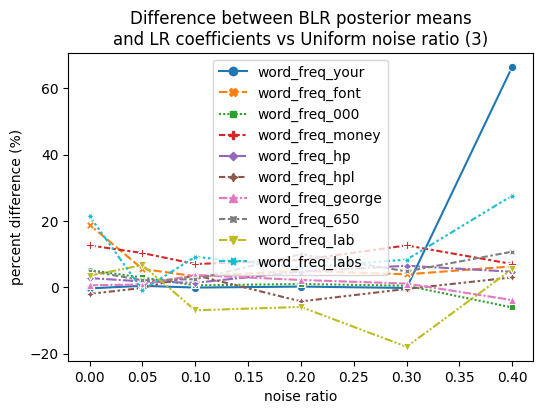

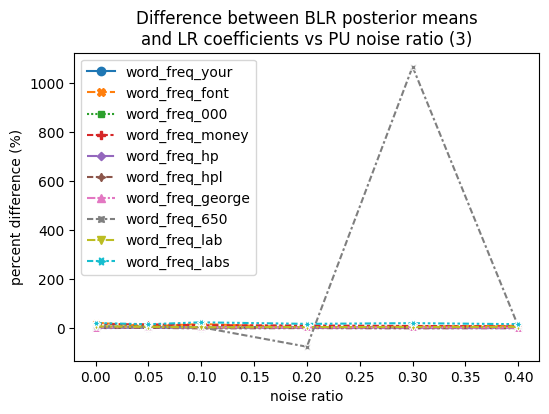

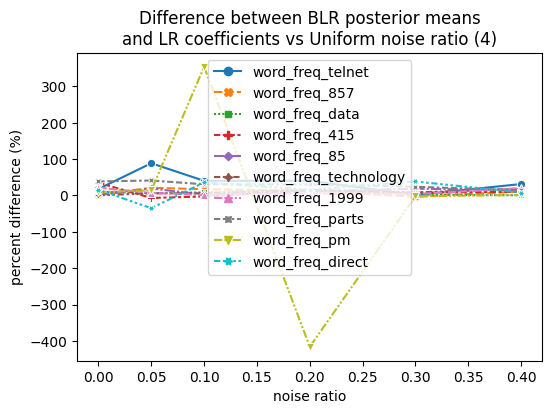

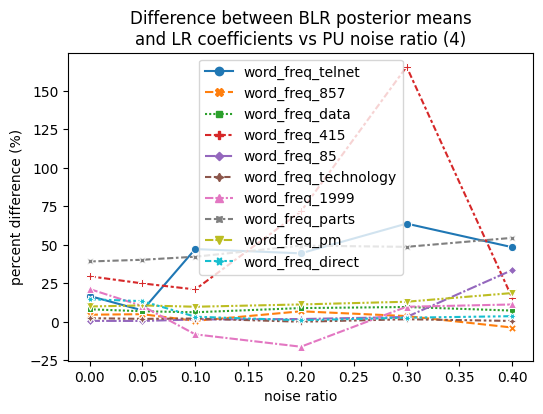

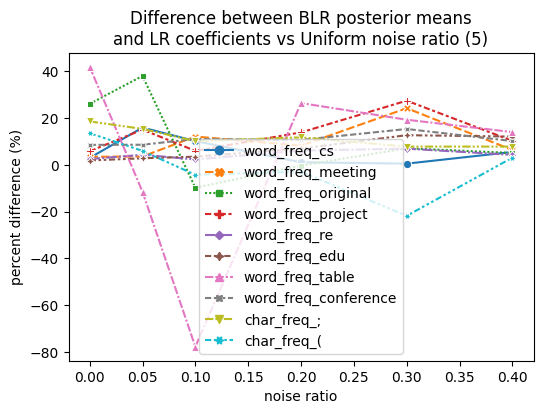

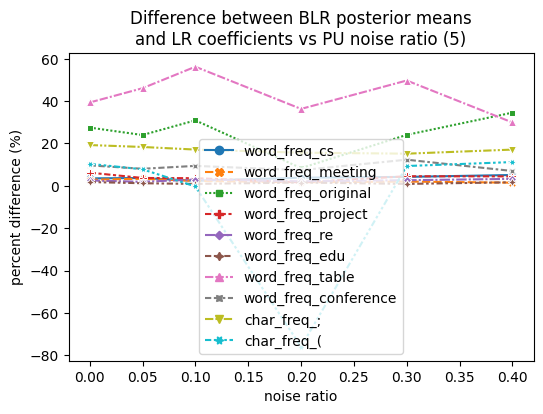

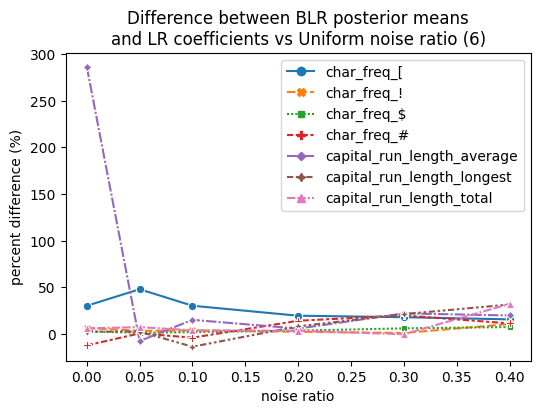

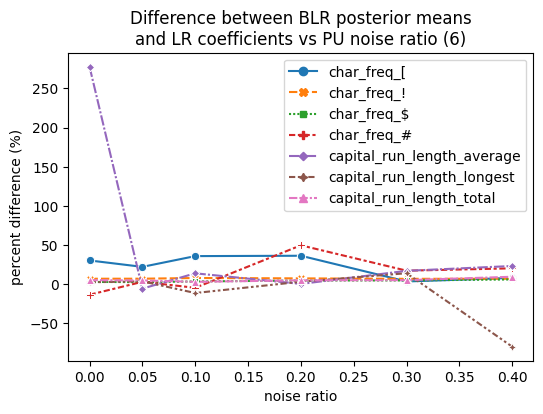

In [43]:
for i in range(6):
    feats = features[i*10 : min(i*10+10,len(features))]
    
    title = f'Difference between BLR posterior means\nand LR coefficients vs Uniform noise ratio ({i+1})'
    fig, ax = blreval.generate_diff_plot(feats, noise_space, meandiffs[:6], title)
    fig.savefig(f'diffs_uniform_noise_{i+1}.png')
    
    title = f'Difference between BLR posterior means\nand LR coefficients vs PU noise ratio ({i+1})'
    fig, ax = blreval.generate_diff_plot(feats, noise_space, meandiffs[6:], title)
    fig.savefig(f'diffs_pu_noise_{i+1}.png')

### Performance

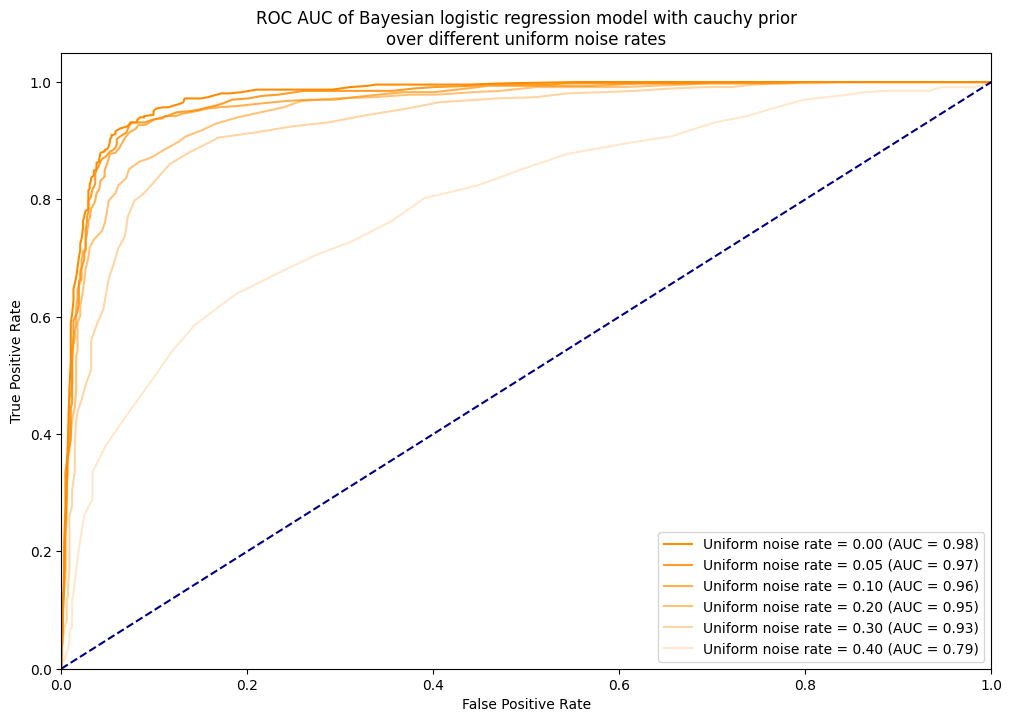

In [24]:
fig, ax = blreval.generate_multiple_roc(
    y_tests[:6],
    blr_preds[:6],
    [{
        'alpha': 1-(0.16 * i),
        'color': 'darkorange',
        'label': "Uniform noise rate = %.2f (AUC = {:.2f})" % noise_space[i]
    } for i in range(6)],
    f'ROC AUC of Bayesian logistic regression model with {prior} prior\nover different uniform noise rates'
)
fig.savefig(f'roc_auc_blr_uniform_{prior}_prior.png')

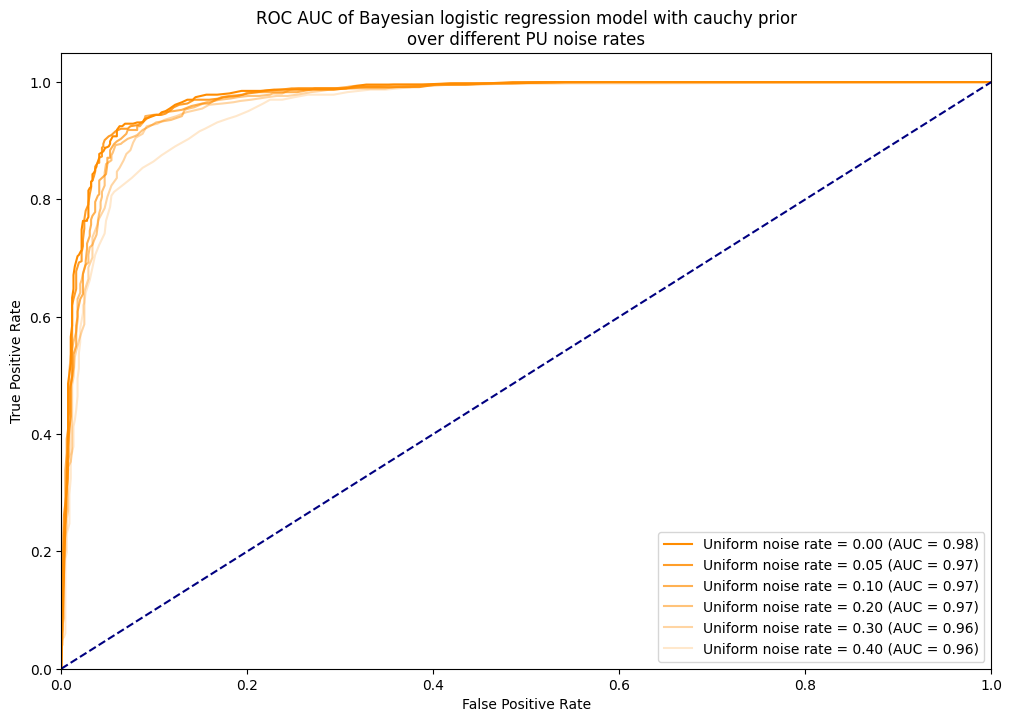

In [25]:
fig, ax = blreval.generate_multiple_roc(
    y_tests[6:],
    blr_preds[6:],
    [{
        'alpha': 1-(0.16 * i),
        'color': 'darkorange',
        'label': "Uniform noise rate = %.2f (AUC = {:.2f})" % noise_space[i]
    } for i in range(6)],
    f'ROC AUC of Bayesian logistic regression model with {prior} prior\nover different PU noise rates'
)
fig.savefig(f'roc_auc_blr_{prior}_prior_pu.png')

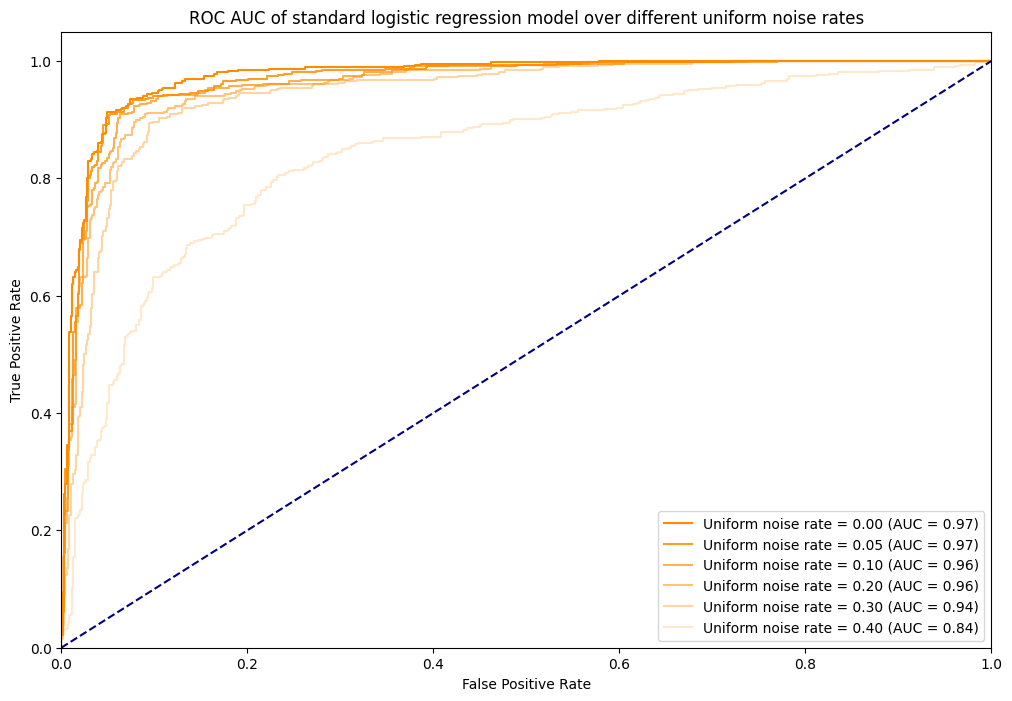

In [26]:
fig, ax = blreval.generate_multiple_roc(
    y_tests[:6],
    lr_preds[:6],
    [{
        'alpha': 1-(0.16 * i),
        'color': 'darkorange',
        'label': "Uniform noise rate = %.2f (AUC = {:.2f})" % noise_space[i]
    } for i in range(6)],
    'ROC AUC of standard logistic regression model over different uniform noise rates'
)
fig.savefig('roc_auc_lr_uniform.png')

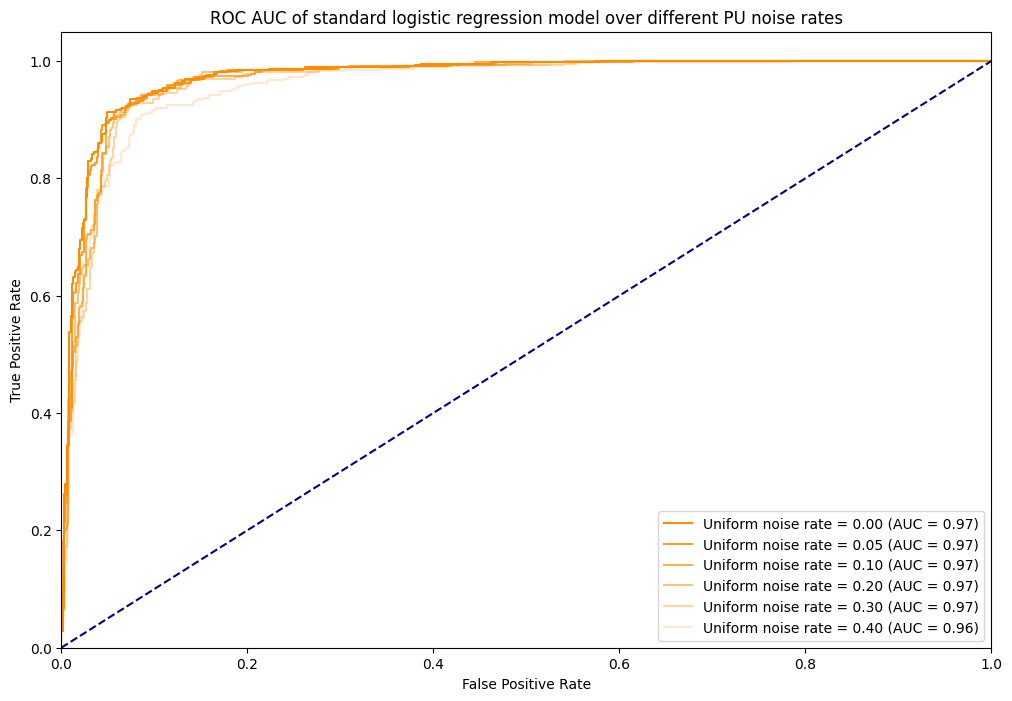

In [27]:
fig, ax = blreval.generate_multiple_roc(
    y_tests[6:],
    lr_preds[6:],
    [{
        'alpha': 1-(0.16 * i),
        'color': 'darkorange',
        'label': "Uniform noise rate = %.2f (AUC = {:.2f})" % noise_space[i]
    } for i in range(6)],
    'ROC AUC of standard logistic regression model over different PU noise rates'
)
fig.savefig('roc_auc_lr_pu.png')